# Baseline model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from hms.layers import AffineLayer, SoftmaxLayer, SigmoidLayer, ReluLayer, LeakyReluLayer
from hms.errors import CrossEntropyError, CrossEntropySoftmaxError, SumOfSquaredDiffsError
from hms.models import SingleLayerModel, MultipleLayerModel
from hms.initialisers import UniformInit, GlorotUniformInit
from hms.learning_rules import GradientDescentLearningRule, AdamLearningRule
from hms.data_providers import HMSDataProvider
from hms.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

In [3]:
# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = HMSDataProvider('train', 'extro', 'Twitter', rng=rng)
valid_data = HMSDataProvider('validation', 'extro', 'Twitter', rng=rng)
input_dim, output_dim = 100, 6

In [3]:
# def train_model_and_plot_stats(
#         model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

#     data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

#     optimiser = Optimiser(
#         model, error, learning_rule, train_data, valid_data, data_monitors)

#     stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

#     # Plot the change in the validation and training set error over training.
#     fig_1 = plt.figure(figsize=(8, 4))
#     ax_1 = fig_1.add_subplot(111)
#     for k in ['error(train)', 'error(valid)']:
#         ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
#                   stats[1:, keys[k]], label=k)
#     ax_1.legend(loc=0)
#     ax_1.set_xlabel('Epoch number')    
#     return stats, keys, run_time, fig_1, ax_1

In [4]:
train_data.inputs.shape

(486827, 100)

In [5]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.01  # scale for random parameter initialisation
learning_rate = 0.001  # learning rate for gradient descent
num_epochs = 30  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
hidden_dim = 15

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim, param_init, param_init),
    ReluLayer(),
    AffineLayer(hidden_dim, output_dim, param_init, param_init),
])

# Initialise a cross entropy error object
error = SumOfSquaredDiffsError()

# Use a basic gradient descent learning rule
learning_rule = AdamLearningRule(learning_rate=learning_rate)

# stats, keys, run_time, fig_1, ax_1 = train_model_and_plot_stats(
#     model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

stats, keys, run_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

Epoch Progress: 100%|██████████| 4868/4868 [00:01<00:00, 2624.73it/s]Epoch 5: 1.9s to complete
    error(train)=3.75e-02, acc(train)=3.77e-01, error(valid)=8.08e-02, acc(valid)=5.74e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:01<00:00, 2619.38it/s]Epoch 10: 1.9s to complete
    error(train)=3.73e-02, acc(train)=3.78e-01, error(valid)=8.11e-02, acc(valid)=5.72e-01
Epoch Progress:  68%|██████▊   | 3331/4868 [00:01<00:00, 2914.27it/s]


Epoch Progress: 100%|██████████| 4868/4868 [00:01<00:00, 2742.58it/s]Epoch 15: 1.8s to complete
    error(train)=3.73e-02, acc(train)=3.79e-01, error(valid)=8.08e-02, acc(valid)=5.78e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:01<00:00, 2686.30it/s]Epoch 20: 1.8s to complete
    error(train)=3.73e-02, acc(train)=3.76e-01, error(valid)=8.10e-02, acc(valid)=5.75e-01
Epoch Progress: 100%|██████████| 4868/4868 [00:02<00:00, 2182.04it/s]Epoch 25: 2.3s to complete
    error(train)=3.72e-02, acc(train)=3.80e-01, error(valid)=8.11e-02, acc(valid)=5.72e-01
Experiment Progress:  83%|████████▎ | 25/30 [00:54<00:12,  2.59s/it]


Epoch Progress: 100%|██████████| 4868/4868 [00:01<00:00, 2680.26it/s]Epoch 30: 1.8s to complete
    error(train)=3.72e-02, acc(train)=3.80e-01, error(valid)=8.14e-02, acc(valid)=5.75e-01
Experiment Progress: 100%|██████████| 30/30 [01:04<00:00,  2.35s/it]


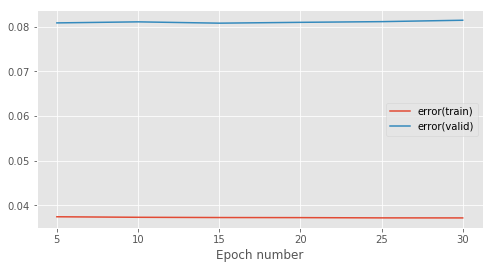

In [6]:
fig_1 = plt.figure(figsize=(8, 4))
ax_1 = fig_1.add_subplot(111)
for k in ['error(train)', 'error(valid)']:
    ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
              stats[1:, keys[k]], label=k)
ax_1.legend(loc=0)
ax_1.set_xlabel('Epoch number')

## Define a function that smooths the output

In [45]:
def smooth_prediction(raw_prediction):
    output_shape = raw_prediction.shape
    # make a matrix that adds 20 lines paddings at the beginning & end of raw prediction
    calculation_frame = np.zeros((output_shape[0]+40, output_shape[1]))
    output = np.zeros(raw_prediction.shape)
    calculation_frame[20:-20, :] = raw_prediction
    
    for i in range(output_shape[0]):
        output[i,:] = calculation_frame[i+20,:] + \
        0.9 * (calculation_frame[i+21,:] + calculation_frame[i+19,:]) + \
        0.9 * (calculation_frame[i+22,:] + calculation_frame[i+18,:]) + \
        0.8 * (calculation_frame[i+23,:] + calculation_frame[i+17,:]) + \
        0.8 * (calculation_frame[i+24,:] + calculation_frame[i+16,:]) + \
        0.7 * (calculation_frame[i+25,:] + calculation_frame[i+15,:]) + \
        0.7 * (calculation_frame[i+26,:] + calculation_frame[i+14,:]) + \
        0.6 * (calculation_frame[i+27,:] + calculation_frame[i+13,:]) + \
        0.6 * (calculation_frame[i+28,:] + calculation_frame[i+12,:]) + \
        0.5 * (calculation_frame[i+29,:] + calculation_frame[i+11,:]) + \
        0.5 * (calculation_frame[i+30,:] + calculation_frame[i+10,:]) + \
        0.4 * (calculation_frame[i+31,:] + calculation_frame[i+9,:]) + \
        0.4 * (calculation_frame[i+32,:] + calculation_frame[i+8,:]) + \
        0.3 * (calculation_frame[i+33,:] + calculation_frame[i+7,:]) + \
        0.3 * (calculation_frame[i+34,:] + calculation_frame[i+6,:]) + \
        0.2 * (calculation_frame[i+35,:] + calculation_frame[i+5,:]) + \
        0.2 * (calculation_frame[i+36,:] + calculation_frame[i+4,:]) + \
        0.1 * (calculation_frame[i+37,:] + calculation_frame[i+3,:]) + \
        0.1 * (calculation_frame[i+38,:] + calculation_frame[i+2,:]) + \
        0.1 * (calculation_frame[i+39,:] + calculation_frame[i+1,:])
    output /= 3
    return output

## Produce output of test sets

Error:    0.000190595638382


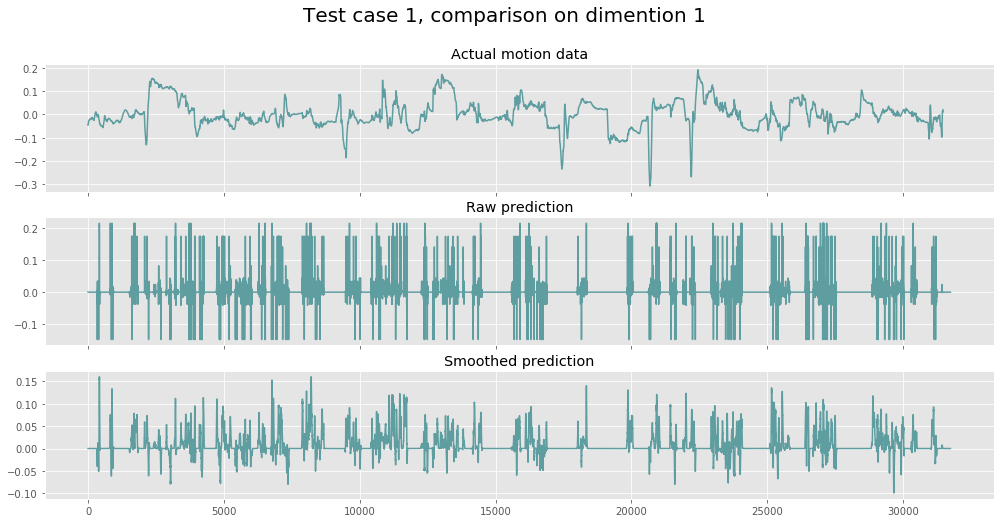

Error:    0.00028485925929


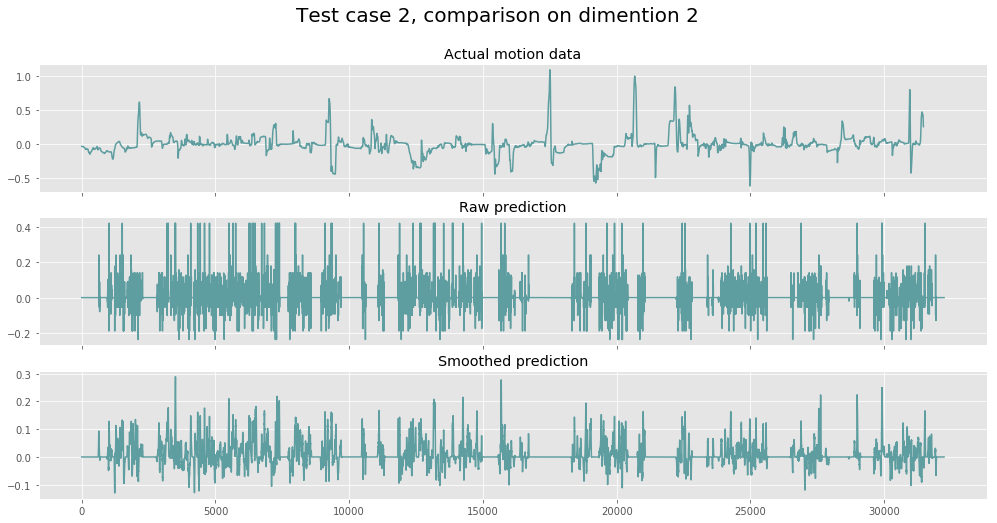

Error:    0.000285639844485


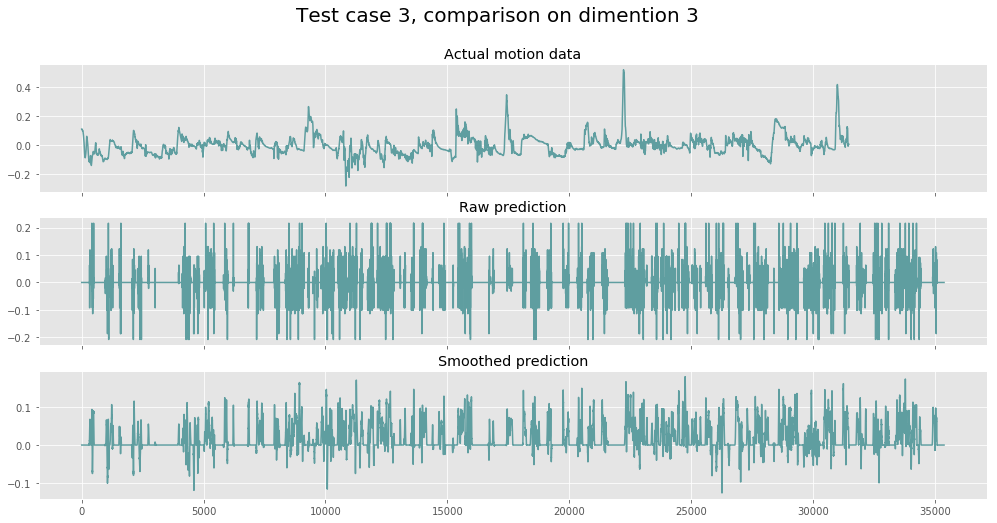

Error:    0.000271060785677


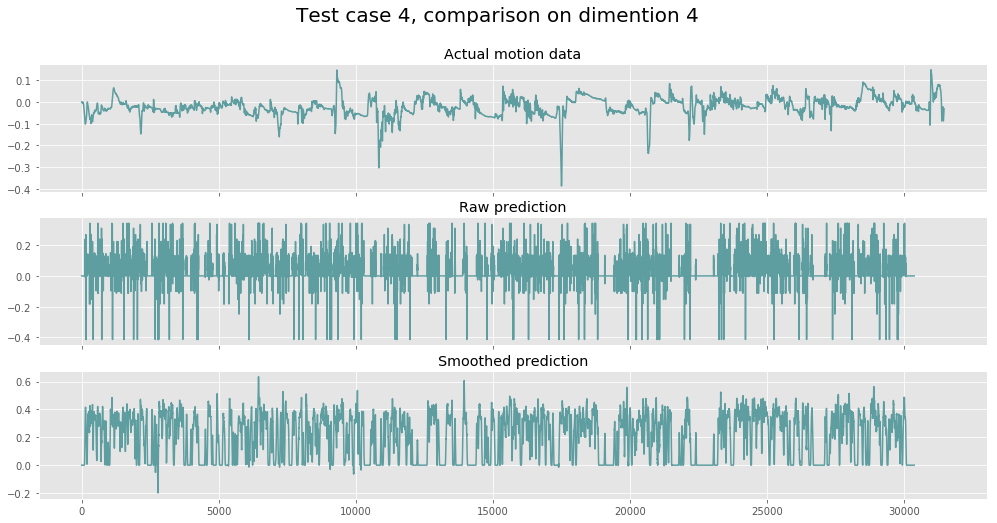

Error:    0.000151072475133


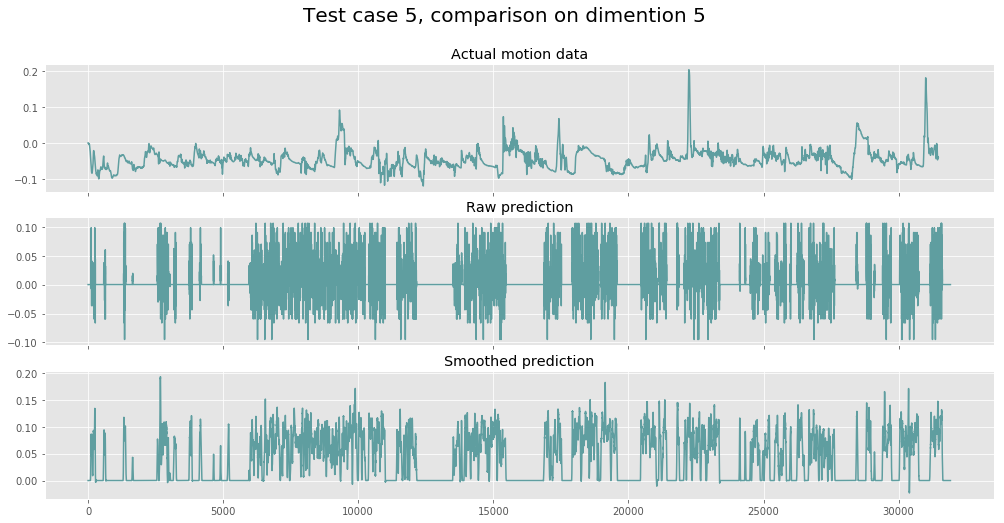

Error:    0.0020169475942


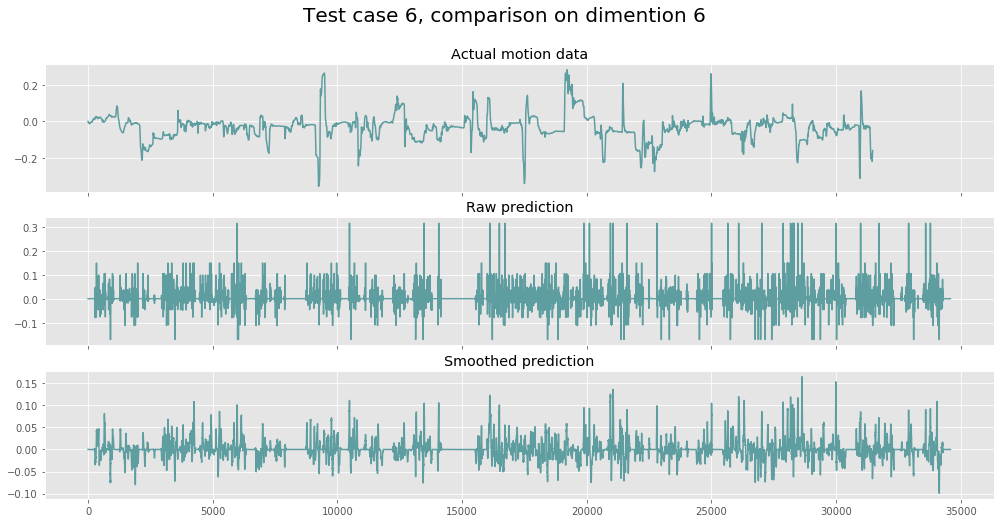

In [62]:
# Loop over 1-6 test cases

for i in range(1,7):
    test_data = HMSDataProvider('test{0}'.format(i), rng=rng)
    result, evaluation = optimiser.eval_test_set(test_data, 'test')
    print('Error:    ' + str(evaluation['errortest']))
    
    time_intervals = np.loadtxt("ExtrovertRawData/Words/{0}".format(i), usecols=range(4, 6), dtype="int")
    prediction = np.zeros((time_intervals[-1,1] + 300, 6))
    counter = 0
    for line in time_intervals:
        for j in range(line[0], line[1]):
            prediction[j] = result[3][counter]
            counter += 1
    prediction_smooth = smooth_prediction(prediction)

    prediction_tan = np.tan(2.5*prediction_smooth) / 4.0

    np.savetxt('Predictions/prediction{0}.txt'.format(i), prediction, fmt="%.7f")
    np.savetxt('Predictions/prediction{0}_smooth.txt'.format(i), prediction_smooth, fmt="%.7f")
    # np.savetxt('prediction{0}_tan.txt'.format(i), prediction_tan, fmt="%.7f")
    
    motion_data = np.loadtxt("ExtrovertRawData/Motion/1.rov".format(i), skiprows=17, usecols=range(0, 6))

    # Two subplots, the axes array is 1-d
    f, axarr = plt.subplots(3, sharex=True, figsize=(17,8))
    axarr[0].plot(motion_data[:,i-1], color = 'cadetblue')
    axarr[0].set_title('Actual motion data')
    axarr[1].plot(prediction[:,i-1], color = 'cadetblue')
    axarr[1].set_title('Raw prediction')
    axarr[2].plot(prediction_smooth[:,i-1], color = 'cadetblue')
    axarr[2].set_title('Smoothed prediction')
#     axarr[3].plot(prediction_tan[:,i-1])
#     axarr[3].set_title('Tan prediction')
    plt.suptitle('Test case {0}, comparison on dimention {1}'.format(i, i), size = 20)
    plt.savefig('Predictions/Test case {0}, comparison on dimention {1}.pdf'.format(i, i))
    plt.show()